# Détermination des loyers en Californie
Solène Duchamp & Jérémy Guiselin

______________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________

## Résumé
Ce projet a pour but de déterminer les loyers des appartements en Californie grâce à des informations sur leurs localisations et leurs caractéristiques.

## Approche
Il s'agit d'un problème de régression, que l'on abordera de la façon suivante :
 - Exploration des données / Cleaning
 - Splitting
 - Training et performance des différents algorithmes :
     - Gradient Boosting (celui-ci nous permettra de réduire le nombre de prédicteurs pour la suite)
     - Random Forest
     - Régression Polynomiale
 

## Imports

In [35]:
import pandas as pd
import ast
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
pd.options.mode.chained_assignment = None
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

## Exploration des données & Cleaning

In [2]:
df = pd.DataFrame.from_csv('data/apartments-geo.csv')
print(df.shape)

(25796, 38)


In [3]:
df.head(2)

,Alarm,Cable Ready,Ceiling Fans,Covered,Double Vanities,Fireplace,Framed Mirrors,Garage,Handrails,Heating,...,features,model,parking,postal_code,rent,size,street_address,full_address,lat,lng
Air Conditioning,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,0,0,1,1,1,...,"['High Speed Internet Access', 'Wi-Fi', 'Air C...",Celebrity Suite,['Garage'],90010,4600.0,1150.0,4121 Wilshire Blvd,4121 Wilshire Blvd 90010 Los Angeles,34.0606,-118.3027
1,0,1,0,0,0,0,0,1,1,1,...,"['High Speed Internet Access', 'Wi-Fi', 'Air C...",Furnished Corporate Ste,['Garage'],90010,6500.0,1150.0,4121 Wilshire Blvd,4121 Wilshire Blvd 90010 Los Angeles,34.0606,-118.3027


In [4]:
df.columns

Index(['Alarm', 'Cable Ready', 'Ceiling Fans', 'Covered', 'Double Vanities',
       'Fireplace', 'Framed Mirrors', 'Garage', 'Handrails', 'Heating',
       'High Speed Internet Access', 'Intercom', 'Satellite TV', 'Smoke Free',
       'Sprinkler System', 'Storage Units', 'Surface Lot',
       'Surface Lot and Covered', 'Surround Sound', 'Trash Compactor',
       'Tub/Shower', 'Washer/Dryer', 'Washer/Dryer Hookup',
       'Wheelchair Accessible (Rooms)', 'Wi-Fi', 'address_locality', 'baths',
       'beds', 'features', 'model', 'parking', 'postal_code', 'rent', 'size',
       'street_address', 'full_address', 'lat', 'lng'],
      dtype='object')

Nous enlevons les colonnes redondantes/ inutiles

In [5]:
df = df.drop(['address_locality','features','postal_code','street_address', 'model', 'parking', 'street_address','full_address', 'lat', 'lng' ], 1)

In [6]:
df.shape

(25796, 29)

Comme nous voulons prédire les loyers, les appartements dont les loyers ne sont pas connus sont inutiles.

In [7]:
df = df[df['rent'] != 0]
df.shape

(20446, 29)

On peut également supprimer les appartements dont la surface ne nous est pas donnée

In [8]:
df = df[df['size'] != 0]
df.shape

(20377, 29)

Regardons les corrélations entre prédicteurs.

In [9]:
# .corr() va directement nous donner la corrélation entre prédicteurs...
df_corr = abs(df.corr())

# ...mais nous ne nous intéressons qu'aux corrélations de plus de 75%
for c in df_corr.columns:
    df_corr[c] = df_corr.apply(lambda x: 1 if x[c] >= 0.75 else 0, axis=1)
df_corr_2 = df_corr.unstack().reset_index(name='value')
df_corr_2[(df_corr_2['value']==1) & (df_corr_2['level_0']!=df_corr_2['level_1'])]

,level_0,level_1,value
751,baths,beds,1
753,baths,size,1
779,beds,baths,1
837,size,baths,1


On remarque que le nombre de salles de bain est corrélé avec le nombre de chambres et la taille de l'appartement,
on peut donc supprimer le prédicteur 'baths'


In [10]:
df = df.drop('baths', 1)
df.shape

(20377, 28)

In [11]:
df.head(2)

,Alarm,Cable Ready,Ceiling Fans,Covered,Double Vanities,Fireplace,Framed Mirrors,Garage,Handrails,Heating,...,Surround Sound,Trash Compactor,Tub/Shower,Washer/Dryer,Washer/Dryer Hookup,Wheelchair Accessible (Rooms),Wi-Fi,beds,rent,size
Air Conditioning,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,0,0,1,1,1,...,0,0,1,0,0,1,1,2,4600.0,1150.0
1,0,1,0,0,0,0,0,1,1,1,...,0,0,1,0,0,1,1,2,6500.0,1150.0


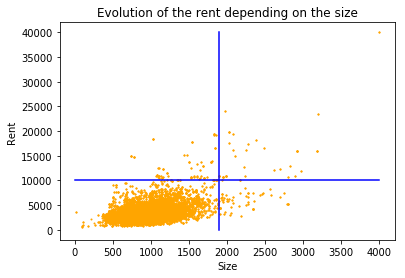

In [12]:
plt.scatter(df['size'], df['rent'], s=1, color='orange')
plt.plot([0,4000],[10000,10000], color='blue')
plt.plot([1900, 1900],[0,40000],color='blue')
plt.xlabel('Size')
plt.ylabel('Rent')
plt.title('Evolution of the rent depending on the size')
plt.show()

On peut donc supprimer les appartements dont le loyer ou la surface sont très importants.

In [13]:
new_df = df[(df['size']<1900) & (df['rent']<10000)]
new_df.shape

(20037, 28)

## Splitting

In [14]:
# On mélange d'abord
new_df = new_df.sample(frac=1)

In [15]:
Y = new_df['rent']
X = new_df.drop('rent', 1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.70, random_state = 42)

/Users/soleneduchamp/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Gradient boosting

Avec une profondeur maximale de 2, on obtient un score de 0.28536051383845074
Avec une profondeur maximale de 4, on obtient un score de 0.3912764149606532
Avec une profondeur maximale de 6, on obtient un score de 0.5434478417678175
Avec une profondeur maximale de 8, on obtient un score de 0.6833514896901752
Avec une profondeur maximale de 10, on obtient un score de 0.7793430897506252
Avec une profondeur maximale de 12, on obtient un score de 0.8340174119488843
Avec une profondeur maximale de 14, on obtient un score de 0.8490225395944755
Avec une profondeur maximale de 16, on obtient un score de 0.848608637555192
Avec une profondeur maximale de 18, on obtient un score de 0.8396269195059881
Avec une profondeur maximale de 20, on obtient un score de 0.8336252012578829
Avec une profondeur maximale de 40, on obtient un score de 0.8296811384458825


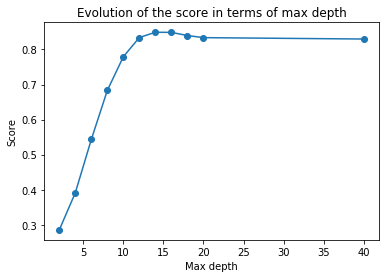

In [16]:
scores = []
max_depth = [2,4,6,8,10,12,14,16,18,20,40]
for depth in max_depth:
    gb = GradientBoostingRegressor(loss='ls' , learning_rate=0.03, n_estimators=100, max_depth=depth)
    kscores = cross_val_score(gb, X_train, Y_train, cv=5)
    scores.append(kscores.mean())
    print ('Avec une profondeur maximale de {0}, on obtient un score de {1}'.format(depth,kscores.mean()))
plt.plot(max_depth, scores, 'o-')
plt.xlabel('Max depth')
plt.ylabel('Score')
plt.title('Evolution of the score in terms of max depth')
plt.show()

On choisit donc une profondeur maximale de 14.


Avec un learning rate de 0.03, on obtient un score de 0.8297045670016789
Avec un learning rate de 0.06, on obtient un score de 0.8246834704696809
Avec un learning rate de 0.09, on obtient un score de 0.8228958150562757
Avec un learning rate de 0.12, on obtient un score de 0.8251492279740067
Avec un learning rate de 0.15, on obtient un score de 0.8243632037207099
Avec un learning rate de 0.18, on obtient un score de 0.823672852105908


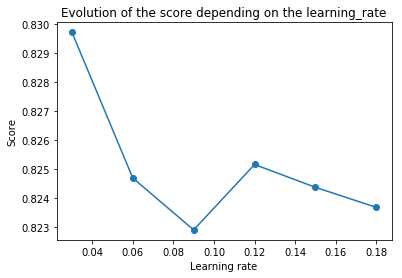

In [17]:
scores = []
l_rates = [0.03, 0.06, 0.09, 0.12, 0.15, 0.18]
for l_r in l_rates:
    gb = GradientBoostingRegressor(loss='ls' , learning_rate=l_r, n_estimators=100, max_depth=14)
    kscores = cross_val_score(gb, X_train, Y_train, cv=5)
    scores.append(kscores.mean())
    print ('Avec un learning rate de {0}, on obtient un score de {1}'.format(l_r, kscores.mean()))
plt.plot(l_rates, scores, 'o-')
plt.xlabel('Learning rate')
plt.ylabel('Score')
plt.title('Evolution of the score depending on the learning_rate')
plt.show()

On constate qu'un faible learning rate a de meilleurs performances, c'est cohérent, puisqu'un faible learning rate apprend plus lentement mais apprend mieux.

Avec 50 estimateurs, on obtient un score de 0.8633319800114195
Avec 100 estimateurs, on obtient un score de 0.8625900807769142
Avec 150 estimateurs, on obtient un score de 0.8641837005418953
Avec 200 estimateurs, on obtient un score de 0.8642618069814627
Avec 300 estimateurs, on obtient un score de 0.862825629770683
Avec 400 estimateurs, on obtient un score de 0.8633251689321305


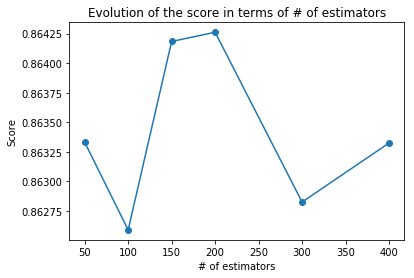

In [18]:
scores = []
estimators = [50,100,150,200,300,400]
for k in estimators:
    gb = GradientBoostingRegressor(loss='ls' , learning_rate=0.18, n_estimators=k, max_depth=14)
    kscores = cross_val_score(gb, X_train, Y_train, cv=5)
    scores.append(kscores.mean())
    print ('Avec {0} estimateurs, on obtient un score de {1}'.format(k,kscores.mean()))
plt.plot([50,100,150,200,300,400], scores, 'o-')
plt.xlabel('# of estimators')
plt.ylabel('Score')
plt.title('Evolution of the score in terms of # of estimators')
plt.show()

On prendra donc 200 estimateurs.

In [19]:
gb = GradientBoostingRegressor(loss='ls' , learning_rate=0.03, n_estimators=200, max_depth=14)
gb.fit(X_train,Y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.03, loss='ls', max_depth=14,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=200,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

On peut donc en profiter pour supprimer les features qui ont peu d'importance

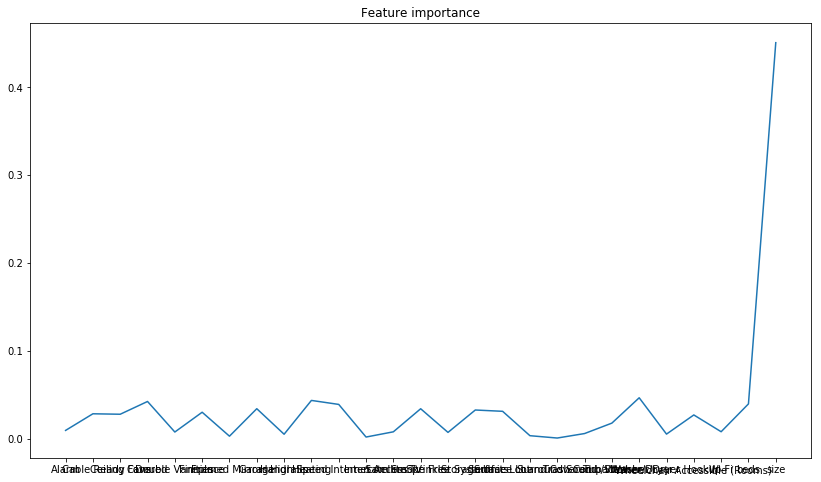

In [21]:
feature_importance = pd.DataFrame({'importance':gb.feature_importances_,'features': X_train.columns.values})
plt.figure(figsize=(14,8))
plt.plot(feature_importance['features'], feature_importance['importance'])
plt.title('Feature importance')
plt.show()

Sans surprise on constate que la surface de l'appartement a une grande importance, et on peut donc en profiter pour supprimer les features insignifiantes.

In [23]:
new_features = feature_importance[feature_importance['importance']>=0.01]
feature_importance.shape, new_features.shape

((27, 2), (15, 2))

On réduit ainsi le nombre de prédicteurs ce qui nous permettra d'aller plus vite avec nos autres algorithmes

In [24]:
#Ces prédicteurs expliquent majoritairement les résultats, à 93%
new_features.sum(axis=0)

features      Cable ReadyCeiling FansCoveredFireplaceGarageH...
importance                                             0.930111
dtype: object

Pour être équitable avec les prochaines prédictions, on fit le modèle de nouveau.

In [28]:
new_features['features'].values

array(['Cable Ready', 'Ceiling Fans', 'Covered', 'Fireplace', 'Garage',
       'Heating', 'High Speed Internet Access', 'Smoke Free',
       'Storage Units', 'Surface Lot', 'Tub/Shower', 'Washer/Dryer',
       'Wheelchair Accessible (Rooms)', 'beds', 'size'], dtype=object)

In [30]:
X_train_r = X_train[['Cable Ready', 'Ceiling Fans', 'Covered', 'Fireplace', 'Garage',
       'Heating', 'High Speed Internet Access', 'Smoke Free',
       'Storage Units', 'Surface Lot', 'Tub/Shower', 'Washer/Dryer',
       'Wheelchair Accessible (Rooms)', 'beds', 'size']]
X_test_r = X_test[['Cable Ready', 'Ceiling Fans', 'Covered', 'Fireplace', 'Garage',
       'Heating', 'High Speed Internet Access', 'Smoke Free',
       'Storage Units', 'Surface Lot', 'Tub/Shower', 'Washer/Dryer',
       'Wheelchair Accessible (Rooms)', 'beds', 'size']]

In [32]:
gb2 = GradientBoostingRegressor(loss='ls' , learning_rate=0.03, n_estimators=200, max_depth=14)
gb2.fit(X_train_r,Y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.03, loss='ls', max_depth=14,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=200,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [33]:
gb2.score(X_test_r, Y_test)

0.89066426518350528

## Random Forest

Avec une profondeur maximale de 2, on obtient un score de 0.21535244636410025
Avec une profondeur maximale de 4, on obtient un score de 0.3045434925984173
Avec une profondeur maximale de 6, on obtient un score de 0.39978723773227065
Avec une profondeur maximale de 8, on obtient un score de 0.5407840146859756
Avec une profondeur maximale de 10, on obtient un score de 0.6778492281532327
Avec une profondeur maximale de 12, on obtient un score de 0.7704758234404416
Avec une profondeur maximale de 14, on obtient un score de 0.821251802649695
Avec une profondeur maximale de 16, on obtient un score de 0.8425233679764842
Avec une profondeur maximale de 18, on obtient un score de 0.8494892716020768
Avec une profondeur maximale de 20, on obtient un score de 0.8507841876724196
Avec une profondeur maximale de 40, on obtient un score de 0.8519120234288806


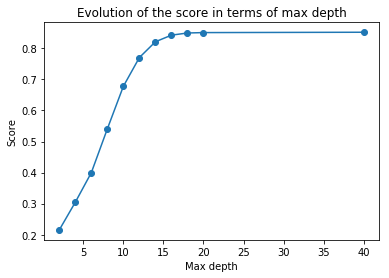

In [36]:
scores = []
max_depth = [2,4,6,8,10,12,14,16,18,20,40]
for depth in max_depth:
    rf = RandomForestRegressor(n_estimators = 75, max_depth = depth)
    kscores = cross_val_score(rf, X_train_r, Y_train, cv=5)
    scores.append(kscores.mean())
    print ('Avec une profondeur maximale de {0}, on obtient un score de {1}'.format(depth,kscores.mean()))
plt.plot(max_depth, scores, 'o-')
plt.xlabel('Max depth')
plt.ylabel('Score')
plt.title('Evolution of the score in terms of max depth')
plt.show()

On prendra donc une profondeur maximale de 16

Regardons maintenant l'influence du nombre d'arbres

Avec 50 estimateurs, on obtient un score de 0.849130805902346
Avec 100 estimateurs, on obtient un score de 0.8501355114832565
Avec 150 estimateurs, on obtient un score de 0.8506625803584396
Avec 200 estimateurs, on obtient un score de 0.8524079824994031
Avec 300 estimateurs, on obtient un score de 0.8526404893787788
Avec 400 estimateurs, on obtient un score de 0.851924501221766


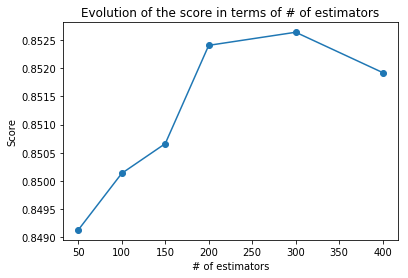

In [37]:
scores = []
estimators = [50,100,150,200,300,400]
for k in estimators:
    rf = RandomForestRegressor(n_estimators=k, max_depth=16)
    kscores = cross_val_score(rf, X_train, Y_train, cv=5)
    scores.append(kscores.mean())
    print ('Avec {0} estimateurs, on obtient un score de {1}'.format(k,kscores.mean()))
plt.plot([50,100,150,200,300,400], scores, 'o-')
plt.xlabel('# of estimators')
plt.ylabel('Score')
plt.title('Evolution of the score in terms of # of estimators')
plt.show()

On prendra donc les hyper-paramètres:
    - 300 arbres
    - profondeur maximale de 16

In [38]:
rf2 = RandomForestRegressor(n_estimators=300, max_depth=16)
rf2.fit(X_train_r,Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=16,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [39]:
rf2.score(X_test_r, Y_test)

0.87265363569566612

## Régression polynomiale

In [42]:
X_train_r.shape

(14025, 15)

Testons d'abord une régression linéaire simple

In [46]:
clf = linear_model.LinearRegression()
cross_val_score(clf, X_train_r, Y_train, cv=5).mean()

0.28934983237498468

Régression polynomiale d'ordre 2

In [47]:
poly = PolynomialFeatures(degree=2)
X_train2 = poly.fit_transform(X_train_r)

clf2 = linear_model.LinearRegression()
cross_val_score(clf2, X_train2, Y_train, cv=5).mean()

0.44362582913155818

In [49]:
poly = PolynomialFeatures(degree=3)
X_train3 = poly.fit_transform(X_train_r)

clf3 = linear_model.LinearRegression()
cross_val_score(clf3, X_train3, Y_train, cv=5).mean()

0.70856212261116802

In [50]:
poly = PolynomialFeatures(degree=4)
X_train4 = poly.fit_transform(X_train_r)

clf4 = linear_model.LinearRegression()
cross_val_score(clf4, X_train4, Y_train, cv=5).mean()

0.58659294400386464

On choisit ainsi la régression polynomiale de degré 3.

In [52]:
poly = PolynomialFeatures(degree=3)
X_train3 = poly.fit_transform(X_train_r)

clf3 = linear_model.LinearRegression()
clf3.fit(X_train_r,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [53]:
clf3.score(X_test_r, Y_test)

0.30808295341863556

On constate une grande erreur de généralisation sur ce modèle.

## Synthèse des résultats

In [79]:
scores = [gb2.score(X_test_r, Y_test), rf2.score(X_test_r, Y_test), clf3.score(X_test_r, Y_test)]
beautiful_scores = pd.DataFrame([[f"{round(x,2)*100} %" for x in scores]])
beautiful_scores.columns = ['Gradient Boosting', 'Random Forest', 'Régression Polynomiale']

In [80]:
beautiful_scores

,Gradient Boosting,Random Forest,Régression Polynomiale
0,89.0 %,87.0 %,31.0 %


> On constate que le Gradient Boosting a les meilleurs performances !!